## 1. 导入库

In [1]:
import os
import sys
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# 添加 UniMatch-V2 到路径
sys.path.insert(0, './UniMatch-V2')

from model.semseg.dpt import DPT
from util.classes import CLASSES

xFormers not available
xFormers not available


## 2. 配置参数

In [4]:
# 配置文件和检查点路径
config_path = './UniMatch-V2/configs/gf7-building.yaml'
checkpoint_path = './data/exp/gf7-building/unimatch_v2/dinov2_base/1_32/best.pth'

# 加载配置
with open(config_path, 'r') as f:
    cfg = yaml.load(f, Loader=yaml.Loader)

print('配置参数:')
print(f"数据集: {cfg['dataset']}")
print(f"类别数: {cfg['nclass']}")
print(f"Backbone: {cfg['backbone']}")
print(f"输入尺寸: {cfg['crop_size']}")

配置参数:
数据集: gf7-building
类别数: 2
Backbone: dinov2_base
输入尺寸: 518


## 3. 加载模型

In [5]:
# 模型配置
model_configs = {
    'small': {'encoder_size': 'small', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'base': {'encoder_size': 'base', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'large': {'encoder_size': 'large', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'giant': {'encoder_size': 'giant', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

# 创建模型
backbone_size = cfg['backbone'].split('_')[-1]
model = DPT(**{**model_configs[backbone_size], 'nclass': cfg['nclass']})

# 加载检查点
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

# 从 DistributedDataParallel 格式加载权重
state_dict = checkpoint['model_ema']  # 使用 EMA 模型通常效果更好
new_state_dict = {}
for k, v in state_dict.items():
    # 去掉 'module.' 前缀
    name = k[7:] if k.startswith('module.') else k
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model.eval()

# 如果有 GPU，使用 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f'模型加载成功！')
print(f'使用设备: {device}')
print(f'检查点 epoch: {checkpoint["epoch"]}')
print(f'最佳 mIoU: {checkpoint["previous_best"]:.2f}%')
print(f'最佳 mIoU (EMA): {checkpoint["previous_best_ema"]:.2f}%')

模型加载成功！
使用设备: cuda
检查点 epoch: 58
最佳 mIoU: 87.50%
最佳 mIoU (EMA): 87.60%


## 4. 图像预处理

In [6]:
def preprocess_image(image_path, size=518):
    """加载和预处理图像"""
    # 读取图像
    img = Image.open(image_path).convert('RGB')
    original_size = img.size

    # 预处理
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img).unsqueeze(0)  # 添加 batch 维度

    return img_tensor, img, original_size

def postprocess_mask(pred, original_size):
    """后处理预测结果"""
    # 将预测 resize 回原始尺寸
    pred = torch.nn.functional.interpolate(
        pred.unsqueeze(0).unsqueeze(0).float(),
        size=original_size[::-1],  # (height, width)
        mode='nearest'
    ).squeeze(0).squeeze(0).long()

    return pred.cpu().numpy()

print('预处理函数定义完成')

预处理函数定义完成


## 5. 推理函数

In [7]:
@torch.no_grad()
def inference(image_path, model, device):
    """对单张图片进行推理"""
    # 预处理
    img_tensor, original_img, original_size = preprocess_image(image_path)
    img_tensor = img_tensor.to(device)

    # 推理
    pred = model(img_tensor)
    pred = pred.argmax(dim=1).squeeze(0)  # 获取类别预测

    # 后处理
    pred_mask = postprocess_mask(pred, original_size)

    return original_img, pred_mask

print('推理函数定义完成')

推理函数定义完成


## 6. 可视化函数

In [9]:
def visualize_prediction(original_img, pred_mask, dataset='coco', alpha=0.5):
    """可视化预测结果"""
    # 创建颜色映射
    np.random.seed(42)
    colors = np.random.randint(0, 255, (cfg['nclass'], 3), dtype=np.uint8)
    colors[0] = [0, 0, 0]  # 背景设为黑色

    # 将预测掩码转换为彩色图
    colored_mask = colors[pred_mask]

    # 创建可视化
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 原始图像
    axes[0].imshow(original_img)
    axes[0].set_title('原始图像', fontsize=14)
    axes[0].axis('off')

    # 预测掩码
    axes[1].imshow(colored_mask)
    axes[1].set_title('预测掩码', fontsize=14)
    axes[1].axis('off')

    # 叠加显示
    original_np = np.array(original_img)
    overlay = (original_np * alpha + colored_mask * (1 - alpha)).astype(np.uint8)
    axes[2].imshow(overlay)
    axes[2].set_title('叠加显示', fontsize=14)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # 显示类别统计
    unique_classes = np.unique(pred_mask)
    print(f'\n检测到的类别数: {len(unique_classes)}')
    print('\n类别统计:')
    for cls_id in unique_classes:
        pixel_count = np.sum(pred_mask == cls_id)
        percentage = 100.0 * pixel_count / pred_mask.size
        class_name = CLASSES[dataset][cls_id] if cls_id < len(CLASSES[dataset]) else f'Class-{cls_id}'
        print(f'  [{cls_id:2d}] {class_name:20s}: {percentage:6.2f}%')

print('可视化函数定义完成')

可视化函数定义完成


## 7. 运行推理

正在处理图像: data/gf-7-building-4bands/Test/image/Tianjin_970.tif


/tmp/ipykernel_3904/950678349.py:31: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3904/950678349.py:31: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3904/950678349.py:31: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3904/950678349.py:31: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3904/950678349.py:31: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3904/950678349.py:31: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3904/950678349.py:31: UserWarning: Glyph 25513 (\N{CJK UNIFIED IDEOGRAPH-63A9}) missi

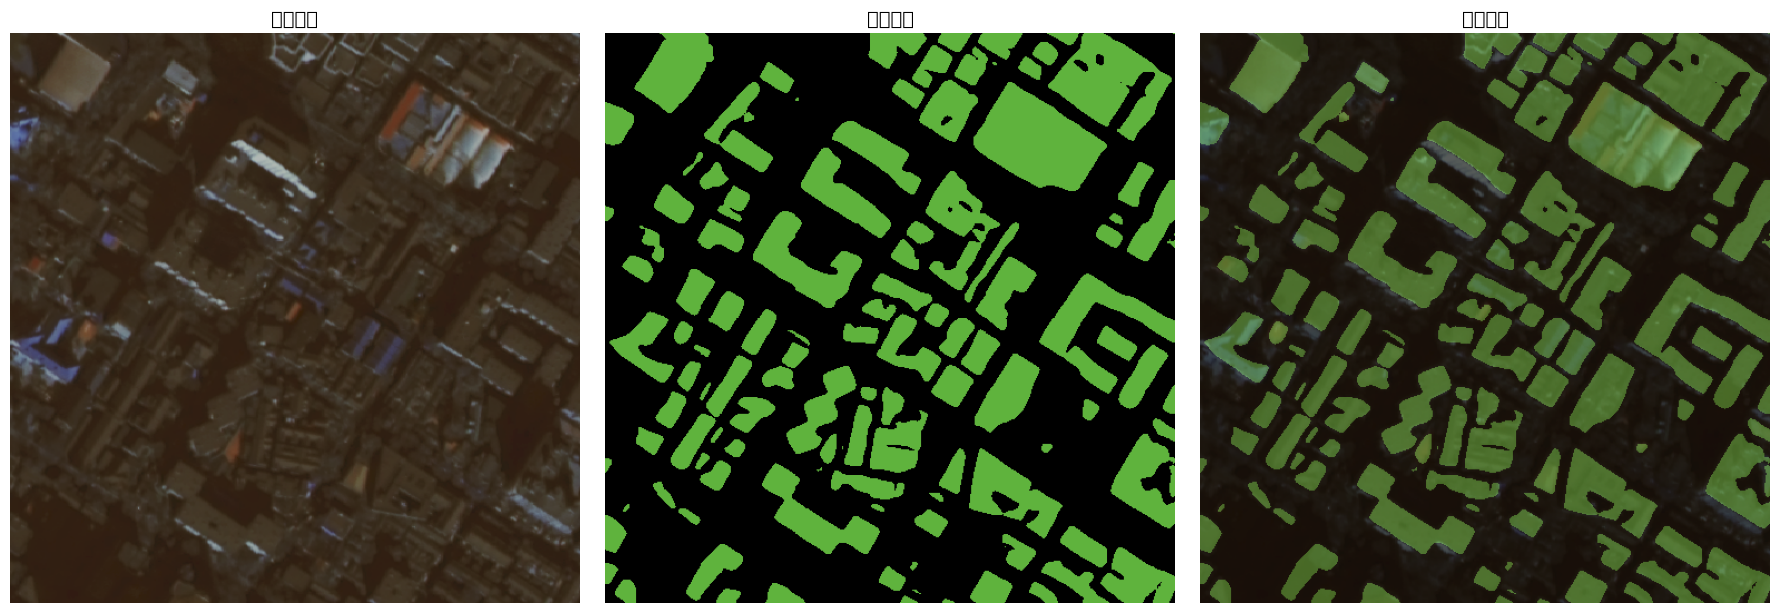


检测到的类别数: 2

类别统计:
  [ 0] background          :  65.03%
  [ 1] building            :  34.97%

推理完成！


In [10]:
# 指定要推理的图像路径
# 请修改为你的图像路径
image_path = 'data/gf-7-building-4bands/Test/image/Tianjin_970.tif'  # 修改此路径

# 检查文件是否存在
if not os.path.exists(image_path):
    print(f'错误: 图像文件不存在: {image_path}')
    print('请修改 image_path 变量为有效的图像路径')
else:
    # 执行推理
    print(f'正在处理图像: {image_path}')
    original_img, pred_mask = inference(image_path, model, device)

    # 可视化结果
    visualize_prediction(original_img, pred_mask, dataset=cfg['dataset'])

    print('\n推理完成！')

In [14]:
CLASSES["coco"][21]

'elephant'

## 8. 批量推理（可选）

图像数量: 3
模型数量: 5
模型列表: ['UniMatch-v2 1/4', 'UniMatch-v2 1/8', 'UniMatch-v2 1/16', 'UniMatch-v2 1/32', 'Supervised(DINO-v2)']

加载模型 [1/5]: UniMatch-v2 1/4
路径: ./data/exp/gf7-building/unimatch_v2/dinov2_base/1_4/best.pth
  - 模型类型: UniMatch-v2 (EMA)
  - Epoch: 103
  - Best mIoU (EMA): 88.68%
  推理 [1/3]: Tianjin_970.tif
  推理 [2/3]: Guangzhou_134.tif
  推理 [3/3]: Shenzhen_98.tif
模型 UniMatch-v2 1/4 已释放

加载模型 [2/5]: UniMatch-v2 1/8
路径: ./data/exp/gf7-building/unimatch_v2/dinov2_base/1_8/best.pth
  - 模型类型: UniMatch-v2 (EMA)
  - Epoch: 98
  - Best mIoU (EMA): 88.46%
  推理 [1/3]: Tianjin_970.tif
  推理 [2/3]: Guangzhou_134.tif
  推理 [3/3]: Shenzhen_98.tif
模型 UniMatch-v2 1/8 已释放

加载模型 [3/5]: UniMatch-v2 1/16
路径: ./data/exp/gf7-building/unimatch_v2/dinov2_base/1_16/best.pth
  - 模型类型: UniMatch-v2 (EMA)
  - Epoch: 90
  - Best mIoU (EMA): 87.94%
  推理 [1/3]: Tianjin_970.tif
  推理 [2/3]: Guangzhou_134.tif
  推理 [3/3]: Shenzhen_98.tif
模型 UniMatch-v2 1/16 已释放

加载模型 [4/5]: UniMatch-v2 1/32
路径: ./data/exp/gf7-buil

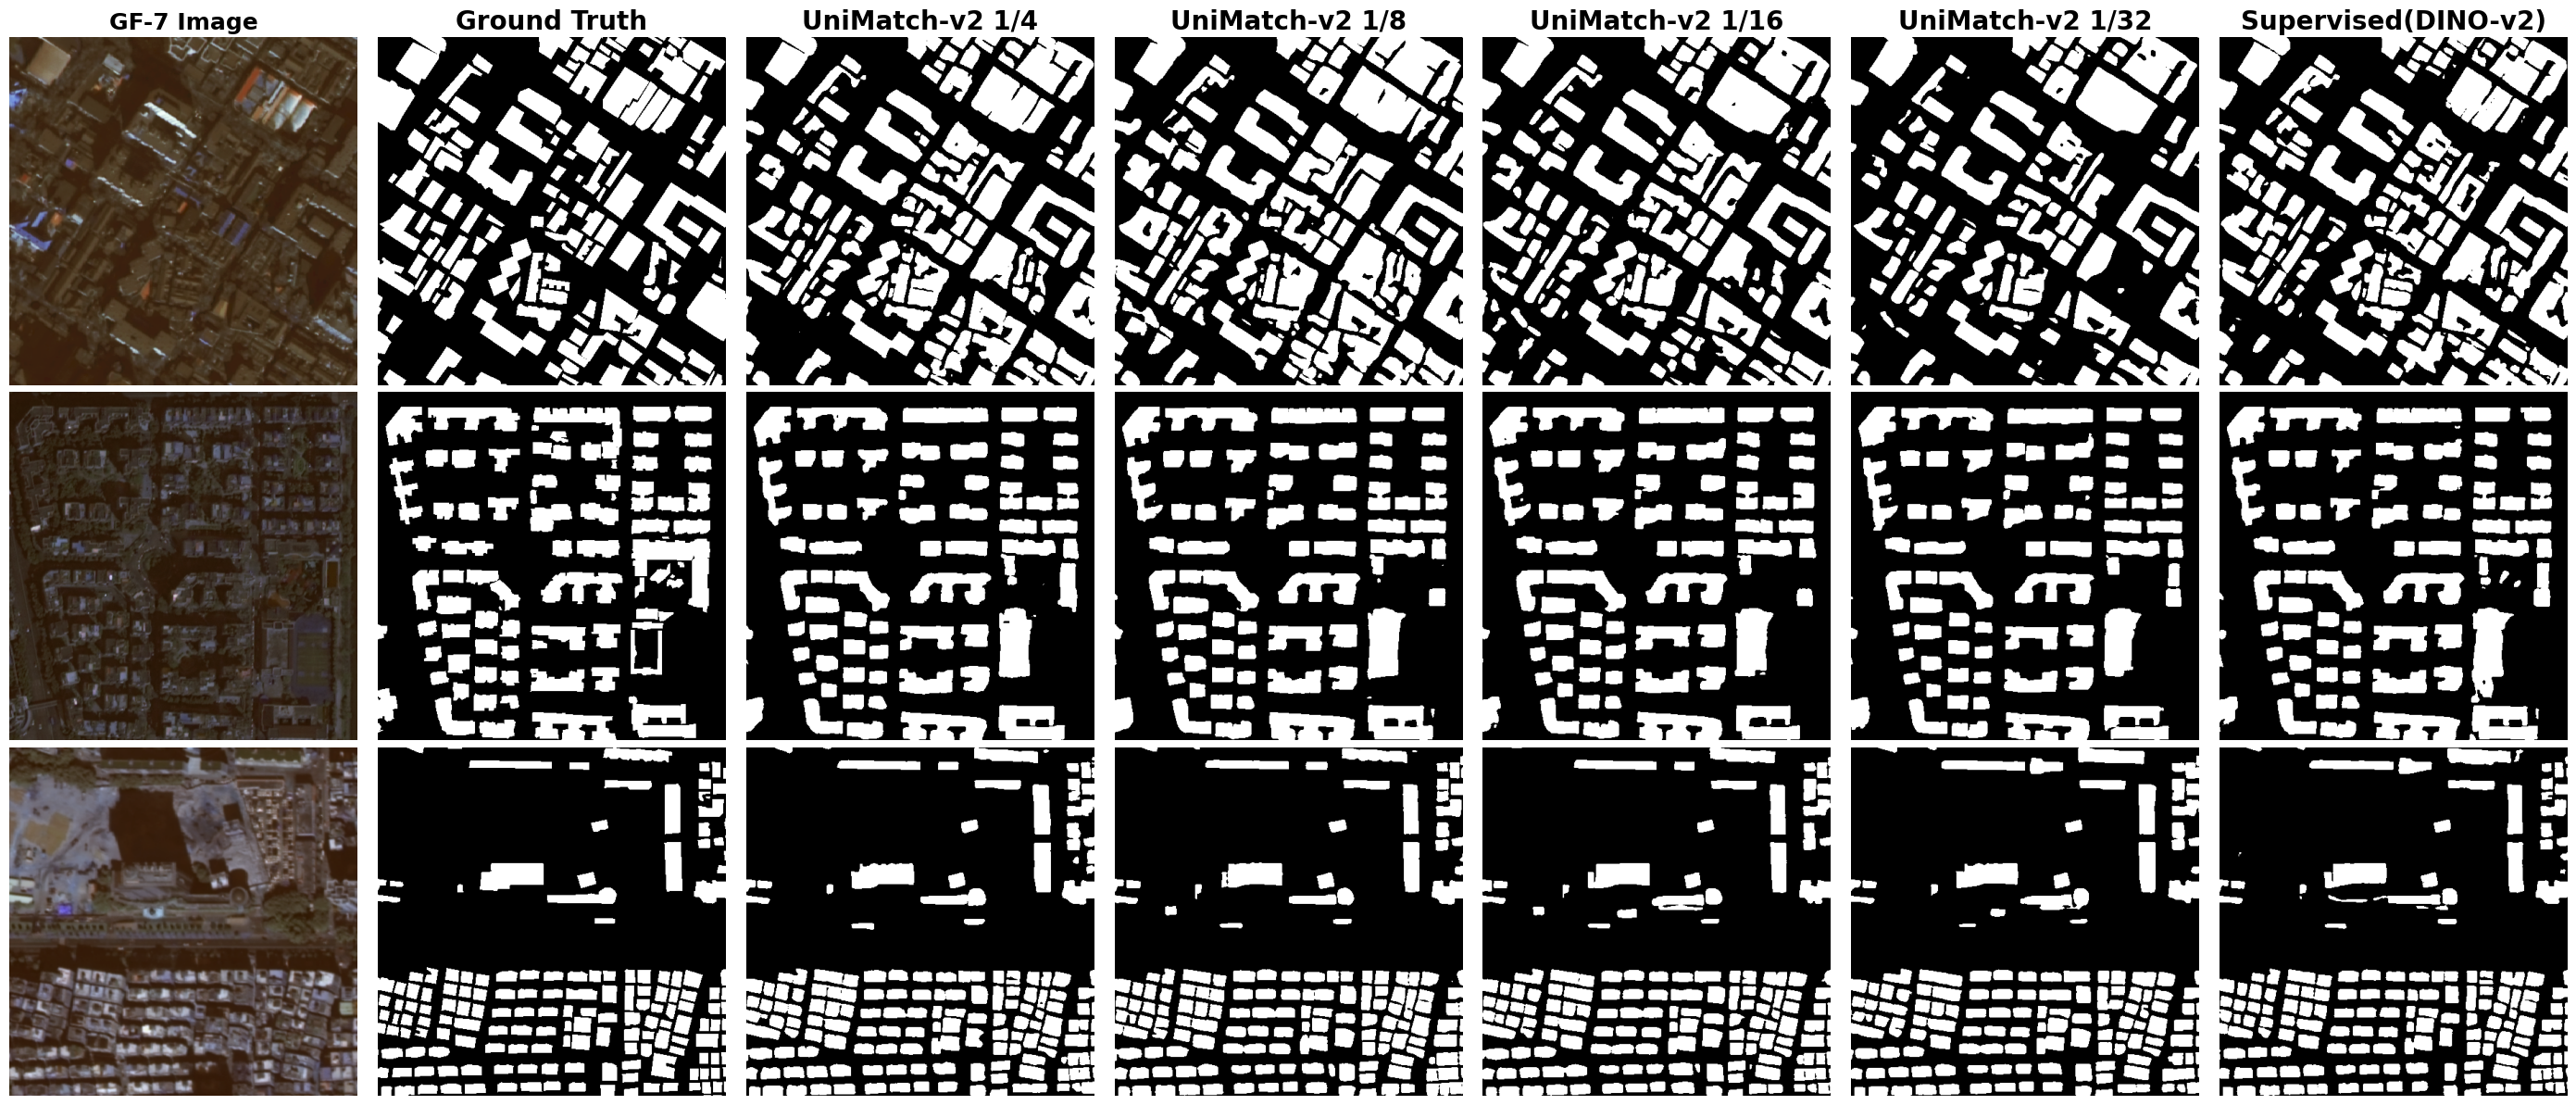


可视化完成！


In [ ]:
import gc
from pathlib import Path

def batch_inference_compare(image_names, model_paths, model_names=None, 
                           image_dir='data/gf-7-building-3bands/Test/image',
                           label_dir='data/gf-7-building-3bands/Test/label'):
    """
    批量推理并对比多个模型的结果
    
    参数:
        image_names: 图像文件名列表，如 ['Tianjin_970.tif', 'Guangzhou_123.tif']
        model_paths: 模型检查点路径列表
        model_names: 模型名称列表（可选，用于显示）
        image_dir: 图像目录
        label_dir: 标签目录
    """
    # 如果没有提供模型名称，使用路径的一部分作为名称
    if model_names is None:
        model_names = [Path(p).parent.name for p in model_paths]
    
    print(f'图像数量: {len(image_names)}')
    print(f'模型数量: {len(model_paths)}')
    print(f'模型列表: {model_names}')
    
    # 存储所有结果: {image_name: {'original': img, 'gt': gt, 'preds': [pred1, pred2, ...]}}
    results = {}
    
    # 对每个图像初始化结果字典
    for img_name in image_names:
        img_path = os.path.join(image_dir, img_name)
        label_path = os.path.join(label_dir, img_name)
        
        # 加载原始图像
        original_img = Image.open(img_path).convert('RGB')
        
        # 加载groundtruth（如果存在）
        gt_mask = None
        if os.path.exists(label_path):
            gt_mask = np.array(Image.open(label_path))
            # 确保标签是二值的：0和1
            # 如果标签值是0和255，转换为0和1
            if gt_mask.max() > 1:
                gt_mask = (gt_mask > 0).astype(np.uint8)
        
        results[img_name] = {
            'original': original_img,
            'gt': gt_mask,
            'preds': []
        }
    
    # 对每个模型进行推理
    for model_idx, (model_path, model_name) in enumerate(zip(model_paths, model_names)):
        print(f'\n{"="*60}')
        print(f'加载模型 [{model_idx+1}/{len(model_paths)}]: {model_name}')
        print(f'路径: {model_path}')
        print(f'{"="*60}')
        
        # 加载模型检查点
        checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
        
        # 创建新模型实例
        temp_model = DPT(**{**model_configs[backbone_size], 'nclass': cfg['nclass']})
        
        # 检测是否为supervised模型（路径中包含'supervised'）
        is_supervised = 'supervised' in model_path.lower()
        
        # 加载权重 - supervised使用'model'，unimatch使用'model_ema'
        if is_supervised:
            state_dict = checkpoint['model']
            print(f'  - 模型类型: Supervised')
        else:
            state_dict = checkpoint['model_ema']
            print(f'  - 模型类型: UniMatch-v2 (EMA)')
        
        new_state_dict = {}
        for k, v in state_dict.items():
            name = k[7:] if k.startswith('module.') else k
            new_state_dict[name] = v
        
        temp_model.load_state_dict(new_state_dict)
        temp_model.eval()
        temp_model = temp_model.to(device)
        
        print(f'  - Epoch: {checkpoint["epoch"]}')
        if is_supervised:
            print(f'  - Best mIoU: {checkpoint.get("previous_best", 0):.2f}%')
        else:
            print(f'  - Best mIoU (EMA): {checkpoint.get("previous_best_ema", 0):.2f}%')
        
        # 对所有图像进行推理
        for img_idx, img_name in enumerate(image_names):
            img_path = os.path.join(image_dir, img_name)
            print(f'  推理 [{img_idx+1}/{len(image_names)}]: {img_name}')
            
            try:
                _, pred_mask = inference(img_path, temp_model, device)
                results[img_name]['preds'].append(pred_mask)
            except Exception as e:
                print(f'    错误: {e}')
                # 添加空预测以保持对齐
                results[img_name]['preds'].append(None)
        
        # 释放模型和内存
        del temp_model
        del checkpoint
        del state_dict
        del new_state_dict
        torch.cuda.empty_cache()
        gc.collect()
        print(f'模型 {model_name} 已释放')
    
    # 可视化所有结果
    print(f'\n{"="*60}')
    print('生成可视化结果')
    print(f'{"="*60}')
    
    visualize_comparison(results, model_names)
    
    return results


def visualize_comparison(results, model_names):
    """
    可视化对比结果
    
    参数:
        results: 结果字典
        model_names: 模型名称列表
    """
    num_images = len(results)
    num_cols = 2 + len(model_names)  # RGB + GT + 各个模型
    
    # 创建图表
    fig, axes = plt.subplots(num_images, num_cols, 
                            figsize=(num_cols * 4, num_images * 4))
    
    # 确保 axes 是二维数组
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    # 列标题
    col_titles = ['GF-7 Image', 'Ground Truth'] + model_names
    
    # 对每个图像
    for row_idx, (img_name, data) in enumerate(results.items()):
        original_img = data['original']
        gt_mask = data['gt']
        pred_masks = data['preds']
        
        # 第一列：原始RGB图像
        # 转换为numpy数组以便进行对比度增强
        img_array = np.array(original_img)
        # 简单的对比度拉伸：将值范围映射到0-255
        img_min, img_max = img_array.min(), img_array.max()
        if img_max > img_min:
            img_stretched = ((img_array - img_min) / (img_max - img_min) * 255).astype(np.uint8)
        else:
            img_stretched = img_array
        
        axes[row_idx, 0].imshow(img_stretched)
        axes[row_idx, 0].axis('off')
        if row_idx == 0:
            axes[row_idx, 0].set_title(col_titles[0], fontsize=22, fontweight='bold')
        axes[row_idx, 0].set_ylabel(img_name, fontsize=22, rotation=0, 
                                     ha='right', va='center')
        
        # 第二列：Ground Truth
        if gt_mask is not None:
            # 黑底白色显示 - gt_mask已经是0和1，需要乘以255
            gt_vis = (gt_mask * 255).astype(np.uint8)
            axes[row_idx, 1].imshow(gt_vis, cmap='gray', vmin=0, vmax=255)
        else:
            axes[row_idx, 1].text(0.5, 0.5, 'N/A', ha='center', va='center', 
                                 fontsize=16, color='red')
        axes[row_idx, 1].axis('off')
        if row_idx == 0:
            axes[row_idx, 1].set_title(col_titles[1], fontsize=22, fontweight='bold')
        
        # 第三列开始：各个模型的预测结果
        for col_idx, pred_mask in enumerate(pred_masks):
            col = col_idx + 2
            
            if pred_mask is not None:
                # 黑底白色显示 - pred_mask也是0和1，需要乘以255
                pred_vis = (pred_mask * 255).astype(np.uint8)
                axes[row_idx, col].imshow(pred_vis, cmap='gray', vmin=0, vmax=255)
            else:
                axes[row_idx, col].text(0.5, 0.5, 'Error', ha='center', va='center',
                                       fontsize=16, color='red')
            
            axes[row_idx, col].axis('off')
            if row_idx == 0:
                axes[row_idx, col].set_title(col_titles[col], fontsize=22, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print('\n可视化完成！')


# 使用示例（取消注释以使用）:

# 定义要测试的图像
image_names = [
    'Tianjin_970.tif',
    'Guangzhou_134.tif',
    'Shenzhen_98.tif'
]

# 定义模型路径
model_paths = [
    './data/exp/gf7-building/unimatch_v2/dinov2_base/1_4/best.pth',
    './data/exp/gf7-building/unimatch_v2/dinov2_base/1_8/best.pth',
    './data/exp/gf7-building/unimatch_v2/dinov2_base/1_16/best.pth',
    './data/exp/gf7-building/unimatch_v2/dinov2_base/1_32/best.pth',
    './data/exp/gf7-building/supervised/dinov2_base/all/best.pth'
]

# 可选：自定义模型名称
model_names = [
    'UniMatch-v2 1/4', 
    'UniMatch-v2 1/8', 
    'UniMatch-v2 1/16', 
    'UniMatch-v2 1/32',
    'Supervised(DINO-v2)'
]

# 运行对比推理
results = batch_inference_compare(
    image_names=image_names,
    model_paths=model_paths,
    model_names=model_names
)

## 9. 保存预测结果（可选）

In [ ]:
# 如果需要保存预测掩码
def save_prediction(pred_mask, output_path):
    """保存预测掩码"""
    Image.fromarray(pred_mask.astype(np.uint8)).save(output_path)
    print(f'预测掩码已保存到: {output_path}')

# 使用示例（取消注释以使用）:
# save_prediction(pred_mask, './output/prediction.png')